![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 6 - RNN </center>
### <center> One to Many RNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex6/Exercise06_RNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [4]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/Exercises/Ex6/DeepLearningFramework ./DeepLearningFramework

In [3]:
import numpy             as np
import matplotlib.pyplot as plt

import torch
import torch.nn    as nn
import torch.optim as optim
import torchtext

from torchtext.vocab import Vocab

### Exercise:
Use the `Names` dataset to generate new names.
* **Input**: A language
* **Output**: A generated name

### Load the data:

In [4]:
mData   = np.load('NamesData.npy')
lNames  = mData[:,0]
lLabels = mData[:,1]
N       = mData.shape[0]

vIdx    = np.random.randint(0, N, (5,))
print(f'Some names : {[f"{lNames [idx]:13}" for idx in vIdx]}')
print(f'Some labels: {[f"{lLabels[idx]:13}" for idx in vIdx]}')

Some names : ['Wakefield    ', 'Mansour      ', 'Balakshin    ', 'Lejava       ', 'Atterton     ']
Some labels: ['English      ', 'Arabic       ', 'Russian      ', 'Russian      ', 'English      ']


#### Build the vocabulary:
We add `<SOS>`, `<EOS>`, and `<PAD>` to the vocabulary

In [5]:
from string          import ascii_letters
from torchtext.vocab import build_vocab_from_iterator

oVocab = build_vocab_from_iterator([c for c in ascii_letters], specials=('<SOS>', '<EOS>', '<PAD>'))
V      = len(oVocab)


print (f'|V| = {V}')
oVocab(['A', 'B', 'C', 'a', 'b', 'z'])

|V| = 55


[3, 4, 5, 29, 30, 54]

#### Label encoder:

In [6]:
from sklearn.preprocessing import LabelEncoder

oLabelEncoder = LabelEncoder().fit(lLabels)
nLabels       = len(oLabelEncoder.classes_)

print(f'Number of labels: {nLabels}'               )
print(f'Labels:         \n{oLabelEncoder.classes_}')

Number of labels: 18
Labels:         
['Arabic' 'Chinese' 'Czech' 'Dutch' 'English' 'French' 'German' 'Greek'
 'Irish' 'Italian' 'Japanese' 'Korean' 'Polish' 'Portuguese' 'Russian'
 'Scottish' 'Spanish' 'Vietnamese']


#### String to tensor:

In [8]:
def Name2Tensor(name):
    lName = list(name) + ['<EOS>']
    return torch.tensor(oVocab(lName))

def Tensor2Name(vName):
    return ''.join([oVocab.get_itos()[e] for e in vName])

name  = 'Jones'
vName = Name2Tensor(name)

Name2Tensor(name), Tensor2Name(vName)

(tensor([12, 43, 42, 33, 47,  1]), 'Jones<EOS>')

#### Dataset:
`__getitem__`:
* `vName` is the tensor version of the string `name`.
* `labelIdx` is the integer represents the class `label`.

In [9]:
class NameDataset(torch.utils.data.Dataset):
    def __init__(self, lNames, lLabels):
        self.lNames  = lNames
        self.lLabels = lLabels
        
    def __len__(self):
        return len(self.lNames)
    
    def __getitem__(self, idx):
        vName    = ???
        labelIdx = ???
        return vName, labelIdx
    
oDataset        = NameDataset(lNames, lLabels)
vName, labelIdx = oDataset[20001]

Tensor2Name(vName), oLabelEncoder.inverse_transform([labelIdx])[0]

('Nguyen<EOS>', 'Vietnamese')

In [10]:
from torch.utils.data import random_split

N                   = mData.shape[0]
nTrain              = 15000
nTest               = N - nTrain
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest], generator=torch.Generator().manual_seed(42))

len(oTrainSet), len(oTestSet)

(15000, 5074)

#### Data loader:
Use `pad_sequence` (and not `packed_sequence`).

In [11]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

def NamesCollate(lBatch):
    lNames, lLabel = zip         (*lBatch)
    vLabel         = torch.tensor(lLabel, dtype=torch.long)
    mName          = pad_sequence(lNames, padding_value=oVocab['<PAD>'], batch_first=True)
    
    return (vLabel, mName)

batchSize = 128
oTrainDL  = DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=NamesCollate)
oTestDL   = DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=NamesCollate)

vLabel, mName  = next(iter(oTrainDL))
vLabel.shape, mName.shape

(torch.Size([128]), torch.Size([128, 14]))

#### RNN decoder:
`forward` implements a single pass through the RNN.

In [12]:
#-- V = Vocabulary
#-- D = Embedding
#-- H = Hidden state
class DecoderRNN(nn.Module):
    def __init__(self, V, D, H):
        super(DecoderRNN, self).__init__()
        self.oEmbedding = nn.???
        self.oGRU       = nn.???
        self.oLinear    = nn.???
        
    def forward(self, vChar, mH):
        #-- vChar.shape = (N,)
        #-- mH   .shape = (1, N, H)
        
        mE     = ???  #-- mE   .shape = (1, N, D)
        _, mH  = ???  #-- mH   .shape = (1, N, H)
        mZ     = ???  #-- mZ   .shape = (N, V)
        return mZ, mH

#### A small test:

In [13]:
V   = len(oVocab)
D   = 16
H   = 32

mH     = torch.randn(1, batchSize, H)
vChar  = mName[:,0]
mZ, mH = DecoderRNN(V, D, H)(vChar, mH)

mZ.shape, mH.shape

(torch.Size([128, 55]), torch.Size([1, 128, 32]))

#### Full model:
The labels are being embedded and feed into the first hidden state.

In [14]:
V = len(oVocab)

class OneToMany(nn.Module):
    def __init__(self):
        super(OneToMany, self).__init__()
        
        D               = 16
        H               = 32
        self.oEmbedding = nn.???    #-- label encoder
        self.oDecoder   = DecoderRNN(???)

    def forward(self, vLabel, mName, pTeacher=0):
        #-- vLabel.shape = (N,)
        #-- mName .shape = (N, T)
        device   = vLabel.device
        N, T     = mName.shape                           
        mLogits  = torch.zeros((N, V, T), device=device) #-- mLogits.shape = (N, V, T)
        bTeacher = torch.rand(1) < pTeacher
                                                         
        #-- Encoder = Embedding
        mLabelE = self.???              #-- mLabelE .shape = (N, H)
        
        mH      = ???                   #-- mH       .shape = (1, N,   H)
        vCharIn = torch.ones(N, device=device)          #-- vCharIn  .shape = (N,)
        vCharIn = oVocab['<SOS>'] * vCharIn.long()
        for ii in range(T):
            mZ, mH          = ??? #-- mZ.shape = (N, V)
                                  #-- mH.shape = (L, N, H)
            mLogits[:,:,ii] = ???
           
            if bTeacher == True:
                vCharIn = ???     #-- vCharIn.shape(N)
            else:
                vCharIn = ???     #-- vCharIn.shape(N)
        
        return mLogits
                
mWordOut = OneToMany()(vLabel, mName, 0.5)
mWordOut.shape

torch.Size([128, 55, 14])

#### Train:

In [15]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mFeatures, mCaption) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mFeatures = mFeatures.to(DEVICE)
        mCaption  = mCaption .to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut = oModel(???, ???, pTeacher=???)
            loss = Loss  (???, ???)
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                ???
                ???

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        with torch.no_grad():
            Nb           = mFeatures.shape[0]
            count       += Nb
            epochLoss   += Nb * loss.item()
            epochMetric += Nb * Metric(mOut, mCaption)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [16]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

DEVICE = torch.device       ("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss(ignore_index=???)
Metric = Accuracy           (ignoreIndex =???)

In [17]:
nEpochs    = 100
nIter      = nEpochs * len(oTrainDL)

oModel     = OneToMany  ().to(DEVICE)
oOptim     = ???
oScheduler = ???
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='OneToMany')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  3.958 | Val loss:  3.832 | Train Metric:  0.040 | Val Metric:  0.078 | epoch time:  3.354 | <-- Checkpoint!
Epoch 001: | Train loss:  3.677 | Val loss:  3.415 | Train Metric:  0.079 | Val Metric:  0.078 | epoch time:  2.099 |
Epoch 002: | Train loss:  3.302 | Val loss:  3.159 | Train Metric:  0.128 | Val Metric:  0.167 | epoch time:  2.106 | <-- Checkpoint!
Epoch 003: | Train loss:  3.087 | Val loss:  3.016 | Train Metric:  0.167 | Val Metric:  0.174 | epoch time:  2.163 | <-- Checkpoint!
Epoch 004: | Train loss:  2.975 | Val loss:  2.920 | Train Metric:  0.181 | Val Metric:  0.192 | epoch time:  2.191 | <-- Checkpoint!
Epoch 005: | Train loss:  2.876 | Val loss:  2.842 | Train Metric:  0.190 | Val Metric:  0.199 | epoch time:  2.148 | <-- Checkpoint!
Epoch 006: | Train loss:  2.802 | Val loss:  2.789 | Train Metric:  0.197 | Val Metric:  0.

Epoch 061: | Train loss:  2.315 | Val loss:  2.687 | Train Metric:  0.301 | Val Metric:  0.207 | epoch time:  2.158 |
Epoch 062: | Train loss:  2.340 | Val loss:  2.665 | Train Metric:  0.293 | Val Metric:  0.210 | epoch time:  2.156 |
Epoch 063: | Train loss:  2.400 | Val loss:  2.654 | Train Metric:  0.279 | Val Metric:  0.209 | epoch time:  2.156 |
Epoch 064: | Train loss:  2.364 | Val loss:  2.656 | Train Metric:  0.289 | Val Metric:  0.209 | epoch time:  2.166 |
Epoch 065: | Train loss:  2.370 | Val loss:  2.651 | Train Metric:  0.286 | Val Metric:  0.210 | epoch time:  2.225 |
Epoch 066: | Train loss:  2.336 | Val loss:  2.680 | Train Metric:  0.297 | Val Metric:  0.210 | epoch time:  2.239 |
Epoch 067: | Train loss:  2.330 | Val loss:  2.658 | Train Metric:  0.297 | Val Metric:  0.209 | epoch time:  2.191 |
Epoch 068: | Train loss:  2.361 | Val loss:  2.680 | Train Metric:  0.289 | Val Metric:  0.201 | epoch time:  2.171 |
Epoch 069: | Train loss:  2.292 | Val loss:  2.651 | Tra

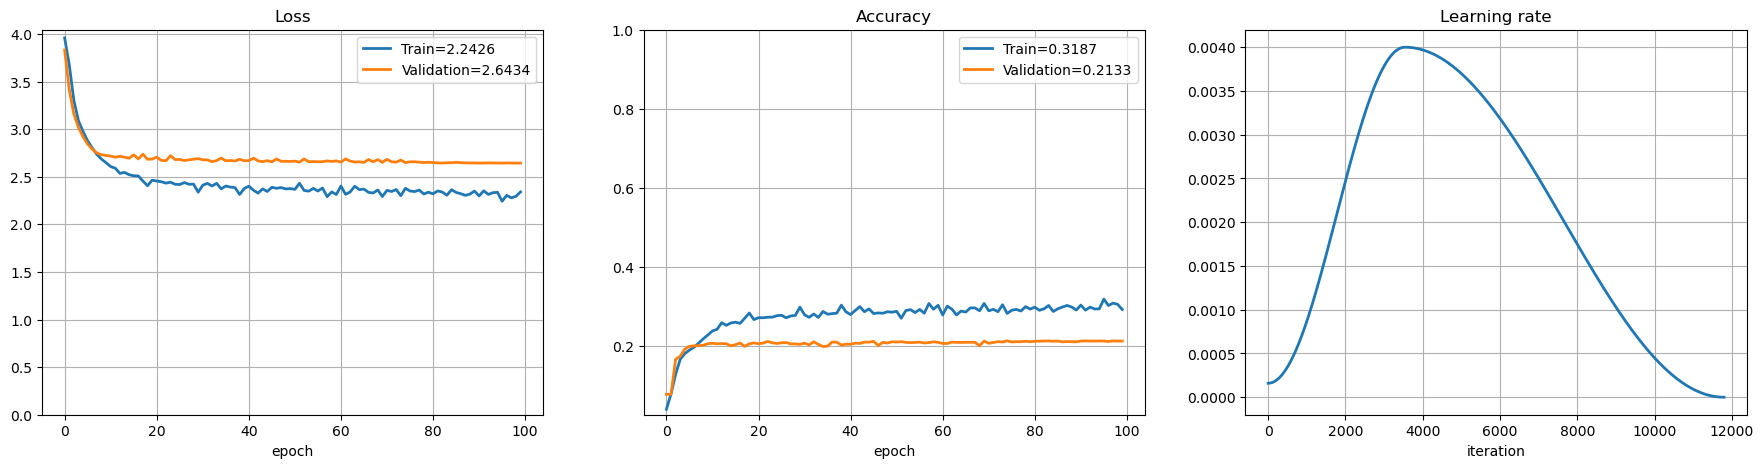

In [20]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

#### Predict function:
* **Input**: A language (as an integer)
* **Output**: A generated name (as a tensor of integers)

In [21]:
from torch.distributions.categorical import Categorical

def Predict(oModel, label, bTop1=False):
    #-- label.shape = ([])
    ???
    
    return 

In [39]:
for idx in range(nLabels):
    label    = oLabelEncoder.inverse_transform([idx])[0]
    labelIdx = torch.tensor(idx).to(DEVICE)

    with torch.no_grad():
        vNameOut = Predict(oModel, labelIdx)

    name = Tensor2Name(vNameOut.int())
    print(f'{idx:02}: {label:10} --> {name}')

00: Arabic     --> Naizab
01: Chinese    --> Shu
02: Czech      --> Gilnyn
03: Dutch      --> Rawelpbare
04: English    --> Riyer
05: French     --> Ronnno
06: German     --> Arrstser
07: Greek      --> Pallatsitotos
08: Irish      --> Ralumain
09: Italian    --> Raonii
10: Japanese   --> Coaroi
11: Korean     --> Chok
12: Polish     --> Jkulli
13: Portuguese --> Tossani
14: Russian    --> Pokachkin
15: Scottish   --> Thert
16: Spanish    --> Gouralis
17: Vietnamese --> Cyh
